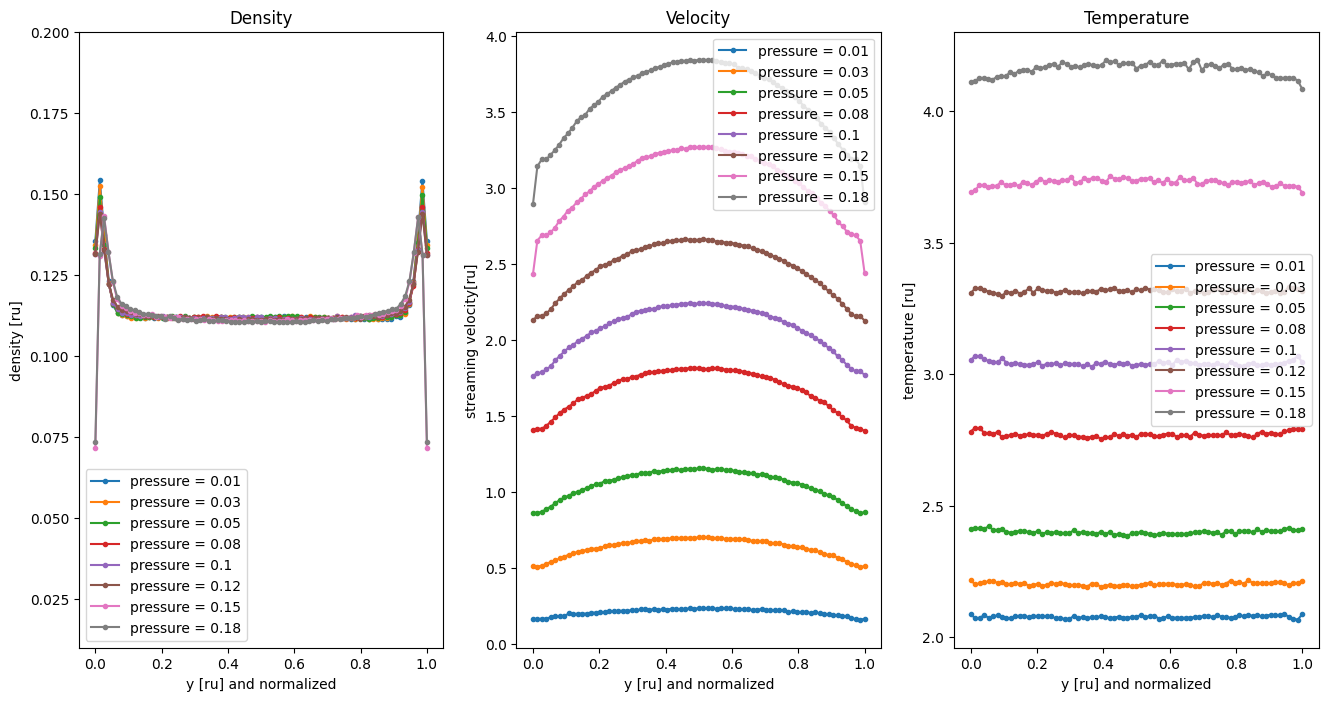

In [61]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

#Function to somewhat clean up the spiking action going on at the walls, only used for velocity
def cleanSpikes(arr,diff,replace):
    newz = []
    for i,coord in enumerate(arr):
        if(i==0):
            newz.append(coord)
            continue
        if(np.abs(coord-newz[-1]) > diff or coord<0):
            newz.append(replace)
        else: newz.append(coord)
    return newz

def getTable(file):
    table = pd.read_csv(file,delimiter=" ",header=None,names=["pos_z","density","velocity","temperature"])
    wall_mask = table["density"] > 0.07
    table["pos_z"] = table["pos_z"][wall_mask]
    table["density"] = table["density"][wall_mask]
    table["velocity"] = table["velocity"][wall_mask]
    table["temperature"] = table["temperature"][wall_mask]

    table["pos_z"] =  table["pos_z"] - table["pos_z"].min()
    return table

def plotAll(ax,table,lbl):
    ax[0].plot(table["pos_z"]/table["pos_z"].max(),table["density"],label=lbl,marker=".")
    ax[0].set_title("Density")
    # ax[0].set_ylim(0.4,0.52)
    ax[0].set_ylim(0.01,0.2)
    ax[0].set_xlabel("y [ru] and normalized")
    ax[0].set_ylabel("density [ru]")
    ax[0].legend()

    ax[1].plot(table["pos_z"]/table["pos_z"].max(),table["velocity"],label=lbl,marker=".")
    ax[1].set_title("Velocity")
    ax[1].set_xlabel("y [ru] and normalized")
    ax[1].set_ylabel("streaming velocity[ru]")
    ax[1].legend()

    ax[2].plot(table["pos_z"]/table["pos_z"].max(),table["temperature"],label=lbl,marker=".")
    ax[2].set_title("Temperature")
    ax[2].set_xlabel("y [ru] and normalized")
    ax[2].set_ylabel("temperature [ru]")
    ax[2].legend()

def plotV(table,lbl):
    plt.plot(table["pos_z"]/table["pos_z"].max(),table["velocity"],label=lbl,marker=".")
    plt.title("Velocity profile")
    plt.xlabel("y [ru] and normalized")
    plt.ylabel("streaming velocity[ru]")
    plt.legend()



def plot(ax,file,lbl,all):
    table = getTable(f'../Tests/{file}.dat')
    if all:
        plotAll(ax,table,lbl)
    else:
        plotV(table,lbl)

all = True

fig,ax = plt.subplots(1,3 if all else 1,sharex=False,figsize=(16 if all else 10,8 if all else 9))

FileCwPairWG = {"WG1":10,"WG2":12,"WG3":15,"WG8":8,"WG9":5,"WG10":6,"WG12":7,"WG14":9}
FilwPPairWG = {"WG1":0.01,"WG4":0.03,"WG5":0.05,"WG6":0.08,"WG7":0.1,"WG11":0.12,"WG13":0.15,"WG15":0.18}

FileCwPairWAu = {"WAu1":10,"WAu2":12,"WAu3":15,"WAu8":8,"WAu9":5,"WAu10":6,"WAu12":7,"WAu14":9}
FilePPairWAu = {"WAu1":0.01,"WAu4":0.03,"WAu5":0.05,"WAu6":0.08,"WAu7":0.1,"WAu11":0.12,"WAu13":0.15,"WAu15":0.18}

files = [FileCwPairWG,FilwPPairWG,FileCwPairWAu,FilePPairWAu]

which = 3

for key,value in files[which].items():
    s = "channel width = "
    if value < 1:
        s = "pressure = "
    plot(ax,key,f'{s}{value}',all)


In [25]:
def parabola(x,a,b,c):
    return x**2*a+x*b+c

def findSlipLengthCF(x,y):
    vars,cov=curve_fit(parabola,x.dropna(),y.dropna(),absolute_sigma=True)
    L_s = -vars[2]/vars[1]
    return np.abs(L_s),vars[0],vars[1],vars[2]

def momentumPFlowEquation(y,rho,mu,P,A,B):
    return y**2/(rho*mu*2)*P-y*A-B

def neumannSlip(Ls,channel_width,rho,mu,P):
    A = (P*channel_width)/(rho*mu*2)
    B = Ls*A
    return A,B


def plotModel(file,P,rho,mu,tanget):
    data = getTable(f'../Tests/{file}.dat')
    cw = data["pos_z"].max() - data["pos_z"].min()
    L_s,a,b,c = findSlipLengthCF(data["pos_z"],data["velocity"])

    A,B = neumannSlip(L_s,cw,rho,mu,P)

    Y = np.linspace(0,cw)

    # plt.plot(data["pos_z"],data["velocity"],label="MD simulation",marker=".")
    # plt.plot(Y,momentumPFlowEquation(Y,rho,mu,P,A,B),label="Theoretical model")
    if tanget:
        Y_t = np.linspace(-L_s,cw/2)
        # plt.plot(Y_t,Y_t*b+c,label="Tangent at y=0")
    # plt.legend()
    # print(f'L_S: {L_s}')
    return L_s,parabola(cw/2,a,b,c)



file = "WAu9"
P = -0.01
rho = 0.44

eps_FF = 30.67*1.6*10**(-22)
sig_FF = 2.735*10**(-10)
m = 2.988*10**(-26)

mu = 0.000399*sig_FF**2/np.sqrt(m*eps_FF)

plotModel(file,P,rho,mu,True)


(4.3337770173965495, 0.07131828369485453)

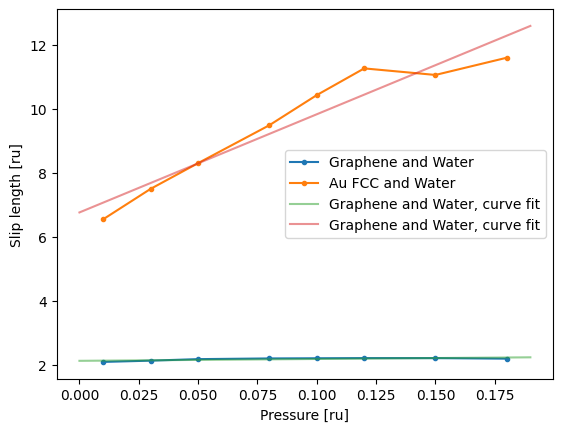

In [ ]:
WG = []
WAu = []

for file in files:
    X = []
    Y = []
    Y2 = []
    sort = dict(sorted(file.items(),key=lambda item: item[1]))
    for key,value in sort.items():
        P = value if value < 1 else 0.01
        rho = 0.44 if "WG" in key else 0.11
        try:
            L_s,u_max = plotModel(key,P,rho,1,False)
        except:
            continue
        X.append(value)
        Y.append(L_s)
        Y2.append(u_max)
    if "WG1" in file.keys():
        WG.append([X,Y])
        WG.append([X,Y2])
    else: 
        WAu.append([X,Y])
        WAu.append([X,Y2])

def line(x,a,b):
    return x*a+b


xlabel = ["Channel width [ru]","Pressure [ru]"]

show = 2

parWG,_ = curve_fit(line,WG[show][0],WG[show][1])
parWAu,_ = curve_fit(line,WAu[show][0],WAu[show][1])

XWG = np.linspace(0,WG[show][0][-1]+WG[show][0][0])
XWAu = np.linspace(0,WAu[show][0][-1]+WAu[show][0][0])

plt.plot(WG[show][0],WG[show][1],label="Graphene and Water",marker=".")
plt.plot(WAu[show][0],WAu[show][1],label="Au FCC and Water",marker=".")

plt.plot(XWG,line(XWG,parWG[0],parWG[1]),label="Graphene and Water, curve fit",alpha=.5)
plt.plot(XWAu,line(XWAu,parWAu[0],parWAu[1]),label="Graphene and Water, curve fit",alpha=.5)

plt.xlabel(xlabel[0] if show<2 else xlabel[1])
plt.ylabel("Slip length [ru]" if show%2 == 0 else "Max momentum [ru]")
plt.legend()